In [14]:
import pandas as pd
from scripts.utils import class_count
df = pd.read_csv("data/concatenated/X_preprocessed.csv")
class_count(df)

Examples:
    Total: 154043
    P: 10007 (6.50% of total)
    S: 64346 (41.77% of total)
    W: 79690 (51.73% of total)



(10007, 64346, 79690)

In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
dir = "data/splits/train_test_val_split_0000/"
train_df = pd.read_csv(dir+"train.csv")
val_df = pd.read_csv(dir+"val.csv")
test_df = pd.read_csv(dir+"test.csv")

y_test = test_df.pop('Class')
x_test = test_df
y_train = train_df.pop('Class')
x_train = train_df
y_val = val_df.pop('Class')
x_val = val_df

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [14]:
import tensorflow as tf
from tensorflow import keras
hln = 512
BATCH_SIZE=64
EPOCHS=50
model = tf.keras.Sequential([
    keras.layers.Dense(hln, activation='relu',input_shape=(x_train.shape[-1],)),
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
    keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='categorical_accuracy',
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)
from time import time
start = time()
baseline_history = model.fit(
    x_train,
    tf.one_hot(y_train, 3),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, tf.one_hot(y_val, depth=3)),
    callbacks=[keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss",verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),])
stop = time()-start

Epoch 1/50
2243/2243 [==============================] - 5s 2ms/step - loss: 0.3492 - categorical_accuracy: 0.8811 - precision: 0.9008 - recall: 0.8570 - auc: 0.9677 - val_loss: 0.3401 - val_categorical_accuracy: 0.8833 - val_precision: 0.9009 - val_recall: 0.8614 - val_auc: 0.9687

Epoch 00001: val_loss improved from inf to 0.34012, saving model to best_model.h5
Epoch 2/50
2243/2243 [==============================] - 5s 2ms/step - loss: 0.2804 - categorical_accuracy: 0.9030 - precision: 0.9147 - recall: 0.8917 - auc: 0.9778 - val_loss: 0.3160 - val_categorical_accuracy: 0.8911 - val_precision: 0.9061 - val_recall: 0.8727 - val_auc: 0.9726

Epoch 00002: val_loss improved from 0.34012 to 0.31604, saving model to best_model.h5
Epoch 3/50
2243/2243 [==============================] - 5s 2ms/step - loss: 0.2650 - categorical_accuracy: 0.9090 - precision: 0.9190 - recall: 0.8989 - auc: 0.9800 - val_loss: 0.3251 - val_categorical_accuracy: 0.8877 - val_precision: 0.9028 - val_recall: 0.8733 - 

In [25]:
baseline_results
prec = baseline_results[2]
reca = baseline_results[3]
f = 2*(prec*reca)/(prec+reca)
print(f)
print(baseline_results)
print(stop)
# model.metrics_names

0.9334679071987924
[0.21030423045158386, 0.9331281781196594, 0.9390923380851746, 0.9279104471206665, 0.9867308735847473]


0.9331281781196594


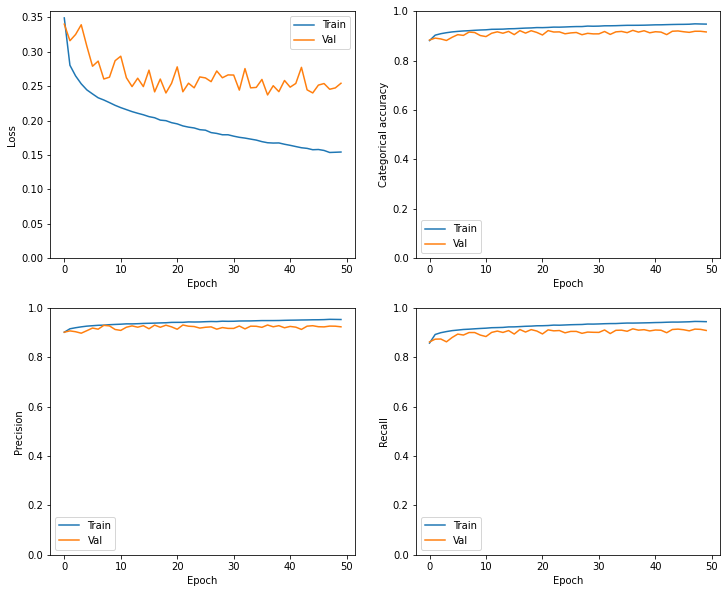

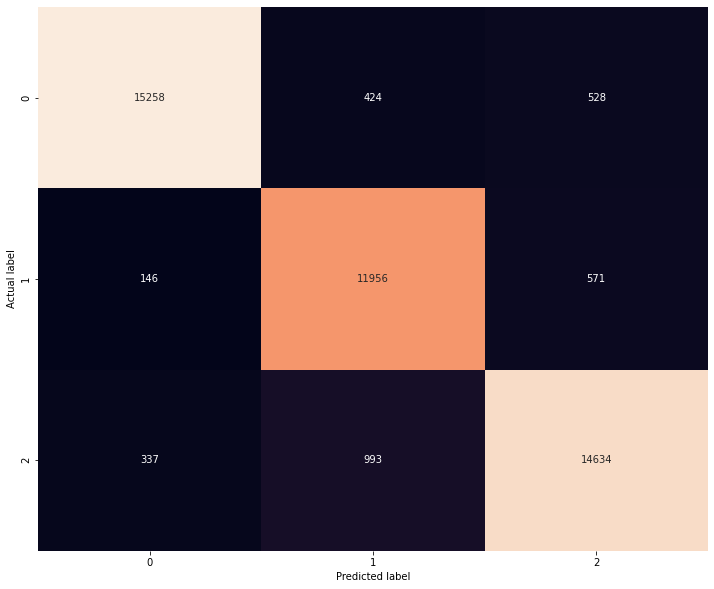

In [15]:
from scripts.utils import *
plt.rcParams["figure.facecolor"] = 'w'
plot_metrics(baseline_history,"",hln)
train_predictions_baseline = model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(x_test, tf.one_hot(y_test,depth=3),
                                    batch_size=BATCH_SIZE, verbose=0)
print(baseline_results[1])
plot_cm(tf.one_hot(y_test,depth=3).numpy().argmax(axis=1),test_predictions_baseline.argmax(axis=1),baseline_results,hln,"All Scored Files")
date = strftime('%X %x').replace("/","").split()
# plt.savefig("figures/"+str(date[1])+"@"+str(date[0][:5].replace(":",""))+"_"+str(hln)+"neurons_confusion_matrix.png",bbox_inches='tight',transparent=False)

/tmp/ipykernel_85188/2879466081.py:32: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


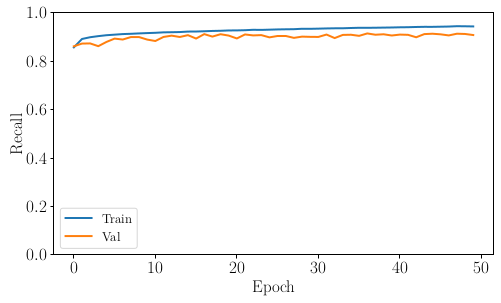

In [22]:
## Plot Metrics Save as PGF
from scripts import *
import matplotlib as mpl
from matplotlib import pyplot as plt
history = baseline_history
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (7.2,4.45)
metrics = ['loss', 'categorical_accuracy','precision','recall']
metric = metrics[3]
name = metric.replace("_"," ").capitalize()
plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
plt.plot(history.epoch, history.history['val_'+metric],
            color=colors[1], label='Val')
plt.xlabel('Epoch')
plt.ylabel(name)
if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
elif metric == 'auc':
    plt.ylim([0.8,1])
else:
    plt.ylim([0,1])
plt.legend()
import matplotlib
matplotlib.use("pgf")
plt.style.use("style.txt")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False
})
plt.show()
plt.savefig(metric+".pgf")


/tmp/ipykernel_85188/3662747112.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


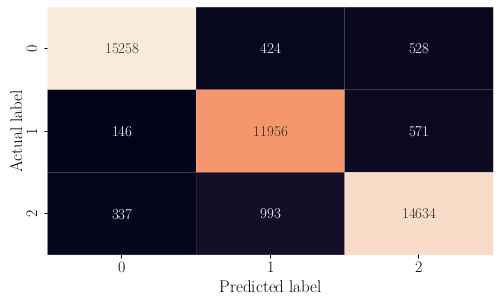

In [23]:
plot_cm(tf.one_hot(y_test,depth=3).numpy().argmax(axis=1),test_predictions_baseline.argmax(axis=1),baseline_results,hln,"All Scored Files")
import matplotlib
matplotlib.use("pgf")
plt.style.use("style.txt")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False
})
plt.show()
plt.savefig("cm.pgf")